# Results of simulation of different fairness policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [12]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [13]:
# Other imports.
import os
import re

# Get logfile paths

In [14]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'lambda=(\d+\.\d+)\.log', logfile_path)
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        l = float(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              l, logfile_path))
    return logfile_paths

In [15]:
policies = ["fifo",
            "max_min_fairness",
            "fifo_perf",
            "fifo_packed",
            "max_min_fairness_perf",
            "max_min_fairness_packed"]
logfile_paths = sorted(get_logfile_paths(
    "/lfs/1/deepak/gpusched/scheduler/logs/new_scheduling_mechanism/"))

# Plotting functions

In [16]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed])

In [17]:
labels = {"fifo": "FIFO",
          "fifo_perf": "FIFO+perf",
          "fifo_packed": "FIFO+perf+packed",
          "max_min_fairness": "MMF",
          "max_min_fairness_perf": "MMF+perf",
          "max_min_fairness_packed": "MMF+perf+packed"}
def plot_metric_vs_inverse_lambda(v100s, p100s, k80s,
                                  policies, metric_fn,
                                  metric_label,
                                  xmax=None,
                                  ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        lambdas = [x[0] for x in relevant_logfile_paths]
        input_job_rates = [3600.0 / x for x in lambdas]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        policies = [labels[policy] for i in range(len(metrics))]

        import pandas as pd
        data["input_job_rate"] += input_job_rates
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

# Plot average JCT versus input job rate

In [18]:
def average_jct_fn(logfile_path, min_job_id=None, max_job_id=None):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Job (\d+): (\d+\.\d+)', line)
            if m is not None:
                job_id = int(m.group(1))
                job_completion_time = float(m.group(2))
                if min_job_id is None or min_job_id <= job_id:
                    if max_job_id is None or job_id <= max_job_id:
                        job_completion_times.append(
                            job_completion_time)
    if len(job_completion_times) == 0:
        return None
    return np.mean(job_completion_times) / 3600

V100s=25, P100s=0, K80s=0; Jobs 4000-5000


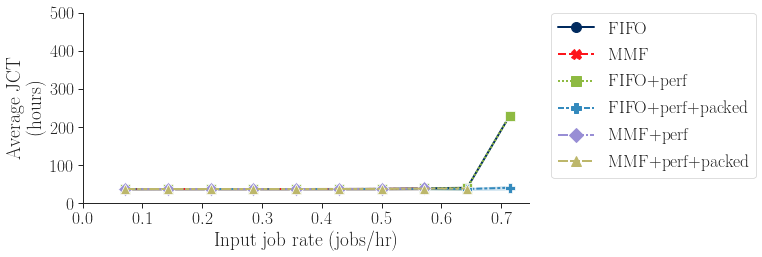

In [19]:
print("V100s=25, P100s=0, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=12, P100s=12, K80s=0; Jobs 4000-5000


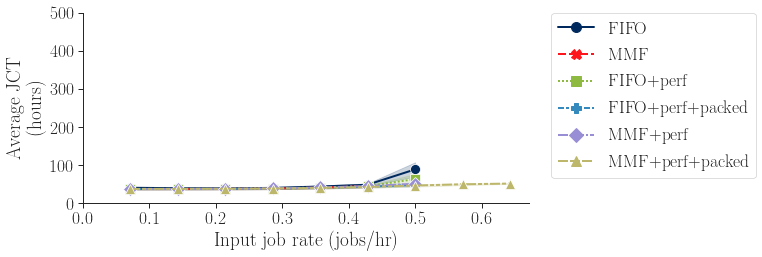

In [20]:
print("V100s=12, P100s=12, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=16, P100s=8, K80s=0; Jobs 4000-5000


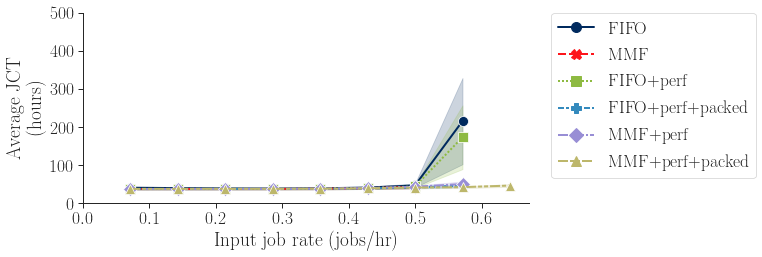

In [21]:
print("V100s=16, P100s=8, K80s=0; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=16, p100s=8, k80s=0,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

V100s=8, P100s=8, K80s=8; Jobs 4000-5000


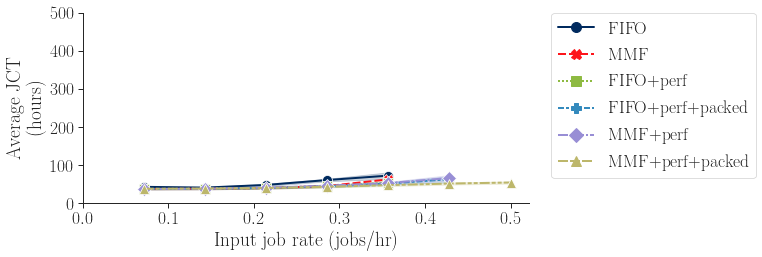

In [22]:
print("V100s=8, P100s=8, K80s=8; Jobs 4000-5000")
plot_metric_vs_inverse_lambda(
    v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT\n(hours)",
    ymax=500.0
)

# Plot utilization versus input job rate

In [12]:
def utilization_fn(logfile_path):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Cluster utilization: (\d+\.\d+)', line)
            if m is not None:
                return float(m.group(1)) * 100.

V100s=25, P100s=0, K80s=0


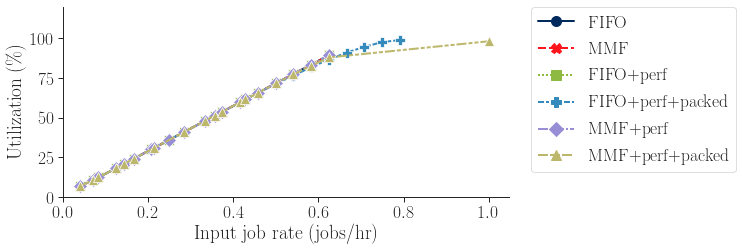

In [13]:
print("V100s=25, P100s=0, K80s=0")
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.
)

V100s=12, P100s=12, K80s=0


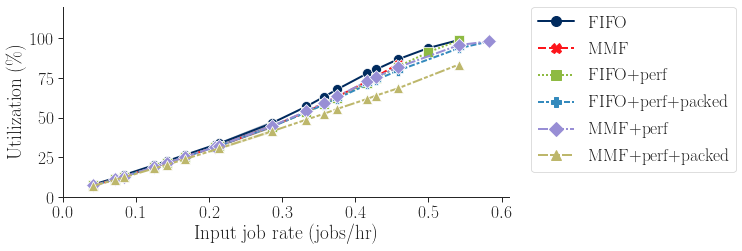

In [14]:
print("V100s=12, P100s=12, K80s=0")
plot_metric_vs_inverse_lambda(
    v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

V100s=16, P100s=8, K80s=0


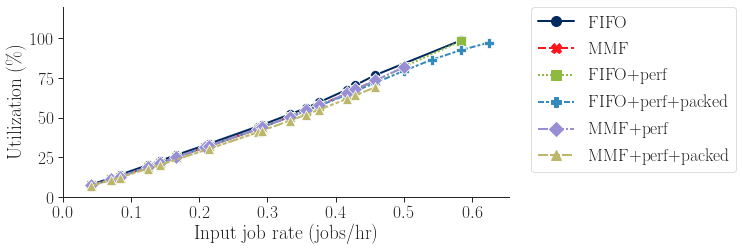

In [15]:
print("V100s=16, P100s=8, K80s=0")
plot_metric_vs_inverse_lambda(
    v100s=16, p100s=8, k80s=0,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

V100s=8, P100s=8, K80s=8


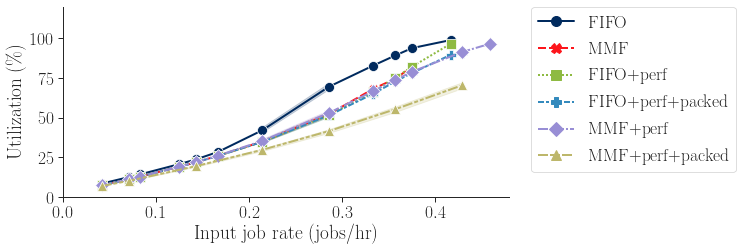

In [16]:
print("V100s=8, P100s=8, K80s=8")
plot_metric_vs_inverse_lambda(
    v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=utilization_fn,
    metric_label="Utilization (\%)",
    ymax=120.0
)

# Plot average JCT versus input job rate on different clusters

In [17]:
costs_per_hour = {"k80": 0.135, "p100": 0.43, "v100": 2.48}
def plot_metric_vs_inverse_lambda_multiple_clusters(cluster_specs,
                                                    policies, metric_fn,
                                                    metric_label,
                                                    xmax=None,
                                                    ymax=None,
                                                    output_filename=None):
    plt.figure(figsize=(16, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"input_job_rate": [], "metric": [], "seed": [],
            "policy": []}
    for (v100s, p100s, k80s) in cluster_specs:
        cost_per_hour = (v100s * costs_per_hour["v100"]) + \
            (p100s * costs_per_hour["p100"]) + \
            (k80s * costs_per_hour["k80"])
        for policy in policies:
            relevant_logfile_paths = list(reversed(prune(
                logfile_paths, v100s, p100s, k80s, policy)))
            lambdas = [x[0] for x in relevant_logfile_paths]
            input_job_rates = [3600.0 / x for x in lambdas]
            metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
            metrics = [metric if metric is not None else None
                       for metric in metrics]
            seeds = [x[2] for x in relevant_logfile_paths]
            policy_labels = [labels[policy] + " (V=%d, P=%d, K=%d)" % (v100s, p100s, k80s)
                             for i in range(len(metrics))]

            import pandas as pd
            data["input_job_rate"] += input_job_rates
            data["metric"] += metrics
            data["seed"] += seeds
            data["policy"] += policy_labels

    sns.lineplot(x='input_job_rate', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Input job rate (jobs/hr)")
    ax.set_ylabel(metric_label)
    ax.set_xlim([0, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

Comparison amongst different clusters; Jobs 4000-5000


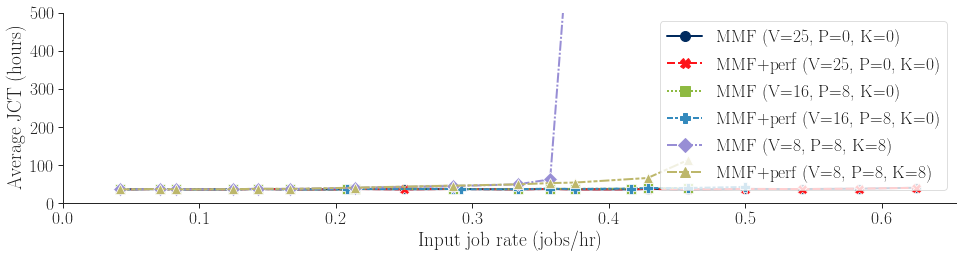

In [18]:
print("Comparison amongst different clusters; Jobs 4000-5000")
plot_metric_vs_inverse_lambda_multiple_clusters(
    cluster_specs=[(25, 0, 0), (16, 8, 0), (8, 8, 8)],
    policies=["max_min_fairness", "max_min_fairness_perf"],
    metric_fn=lambda x: average_jct_fn(x, min_job_id=4000, max_job_id=5000),
    metric_label="Average JCT (hours)",
    ymax=500.0
)

# Plot per-worker timelines

In [19]:
def get_events(logfile_path):
    events = {}
    utilization = None
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            m = re.match(r'(\d+\.\d+).*scheduled.*Job ID: (\d+)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                start_timestamp = float(m.group(1))
                job_id = int(m.group(2))
                worker_type = m.group(3)
                worker_id = int(m.group(4))
                if worker_id not in events:
                    events[worker_id] = []
                events[worker_id].append([job_id, worker_type, start_timestamp,
                                          None])
            m = re.match(r'(\d+\.\d+).*scheduled.*Job ID: \((\d+), (\d+)\)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                start_timestamp = float(m.group(1))
                job_id1 = int(m.group(2))
                job_id2 = int(m.group(3))
                worker_type = m.group(4)
                worker_id = int(m.group(5))
                if worker_id not in events:
                    events[worker_id] = []
                events[worker_id].append([(job_id1, job_id2), worker_type, start_timestamp,
                                          None])
            
            m = re.match(r'(\d+\.\d+).*succeeded.*Job ID: (\d+)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                end_timestamp = float(m.group(1))
                job_id = int(m.group(2))
                worker_type = m.group(3)
                worker_id = int(m.group(4))
                if worker_id not in events:
                    continue
                assert(events[worker_id][-1][0] == job_id and
                       events[worker_id][-1][1] == worker_type and
                       events[worker_id][-1][3] is None)
                events[worker_id][-1][3] = end_timestamp
                
            m = re.match(r'(\d+\.\d+).*succeeded.*Job ID: \((\d+), (\d+)\)\t'
                          'Worker type: (.*)\tWorker ID: (\d+).*',
                         line)
            if m is not None:
                end_timestamp = float(m.group(1))
                job_id1 = int(m.group(2))
                job_id2 = int(m.group(3))
                worker_type = m.group(4)
                worker_id = int(m.group(5))
                if worker_id not in events:
                    continue
                assert(events[worker_id][-1][0] == (job_id1, job_id2) and
                       events[worker_id][-1][1] == worker_type and
                       events[worker_id][-1][3] is None)
                events[worker_id][-1][3] = end_timestamp
                
            m = re.match(r'Cluster utilization: (\d+\.\d+)', line)
            if m is not None:
                utilization = float(m.group(1)) * 100.

    return events, utilization

def plot_timeline(v100s, p100s, k80s, policy, end, seed,
                  output_filename=None):
    relevant_logfile_paths = list(reversed(prune(
        logfile_paths, v100s, p100s, k80s, policy, seed)))
    for i, (lamb, relevant_logfile_path) in enumerate(relevant_logfile_paths):
        if i % 4 != 0:
            continue
        events, utilization = get_events(relevant_logfile_path)

        if utilization is not None:
            plt.figure(figsize=(25, 6))
            ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
            print("Lambda = %.2f" % lamb)

            worker_id_to_type_mapping = {}
            for worker_id in events:
                for (job_id, worker_type, start_timestamp, end_timestamp) \
                    in events[worker_id]:
                    if worker_id not in worker_id_to_type_mapping:
                        worker_id_to_type_mapping[worker_id] = worker_type
                    if start_timestamp < end:
                        if isinstance(job_id, tuple):
                            ax.plot([start_timestamp, min(end_timestamp, end)],
                                    [worker_id, worker_id],
                                    linewidth=10, c="yellow")
                        else:
                            ax.plot([start_timestamp, min(end_timestamp, end)],
                                    [worker_id, worker_id],
                                    linewidth=10, c="C%d" % (job_id % 10))
            print(worker_id_to_type_mapping)
            print("Utilization: %.3f%%" % utilization)

        ax.set_xlabel("Time")
        ax.set_ylabel("Worker ID")
        worker_ids = list(events.keys())
        
        ax.set_yticks(worker_ids)
        ax.set_yticklabels([str(worker_id) for worker_id in worker_ids])
        sns.despine()

        if output_filename is not None:
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')

        plt.show()

These timeline diagrams show the different micro-tasks that run on the different workers. Packed job combinations are in yellow, while single jobs are in other colors.

V100s=25, P100s=0, K80s=0; Max-Min Fairness
Lambda = 86400.00
{}
Utilization: 6.900%


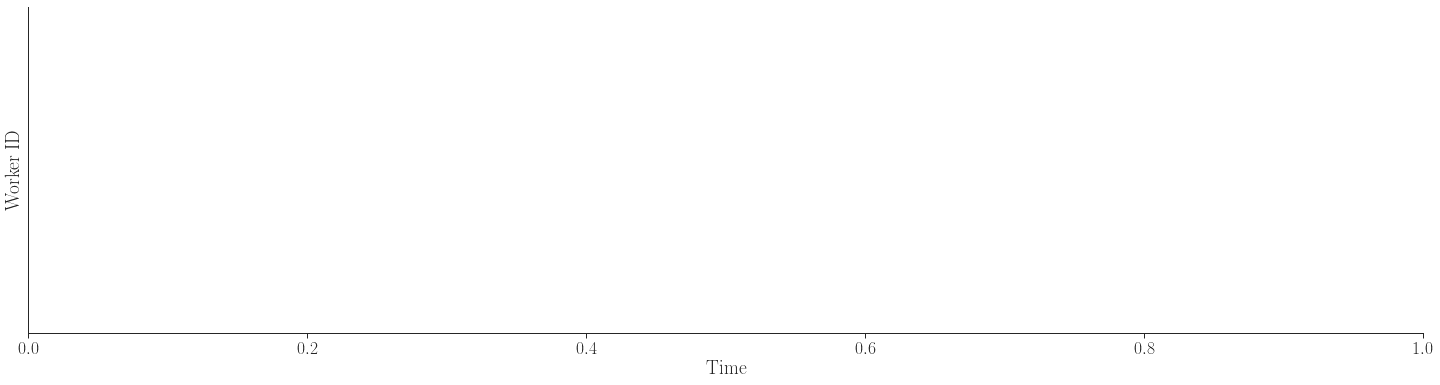

Lambda = 25200.00
{}
Utilization: 20.600%


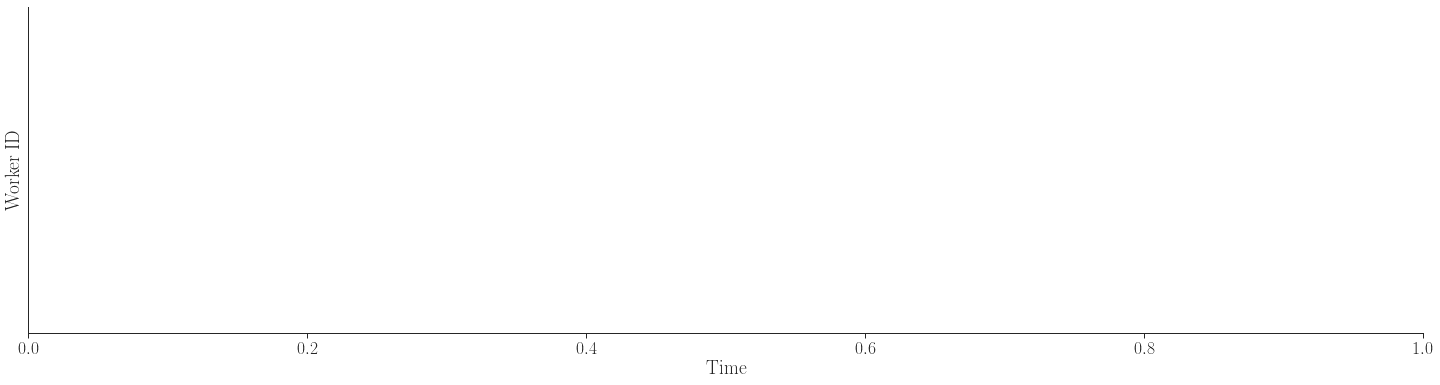

Lambda = 14400.00
{}
Utilization: 35.900%


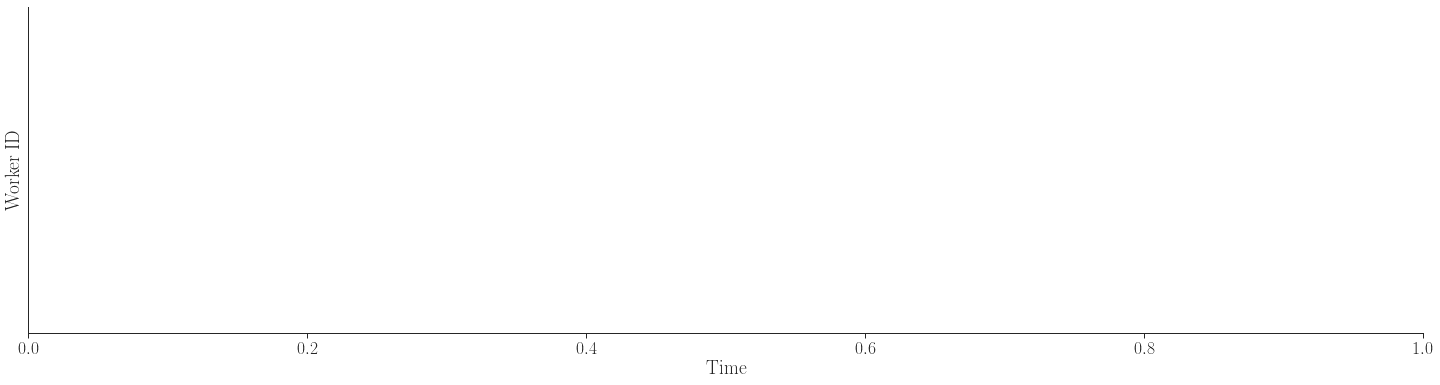

Lambda = 10080.00
{}
Utilization: 51.200%


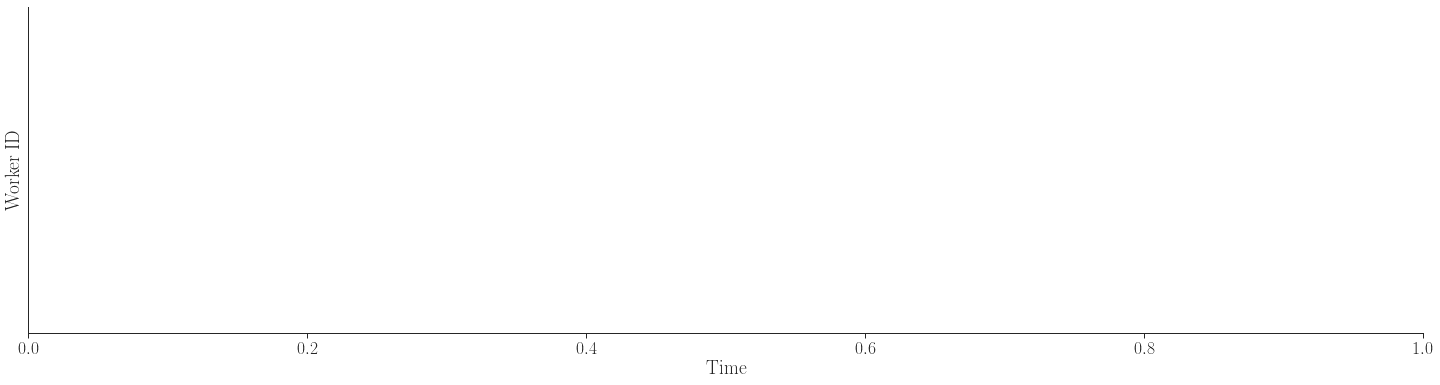

Lambda = 7854.55
{}
Utilization: 65.600%


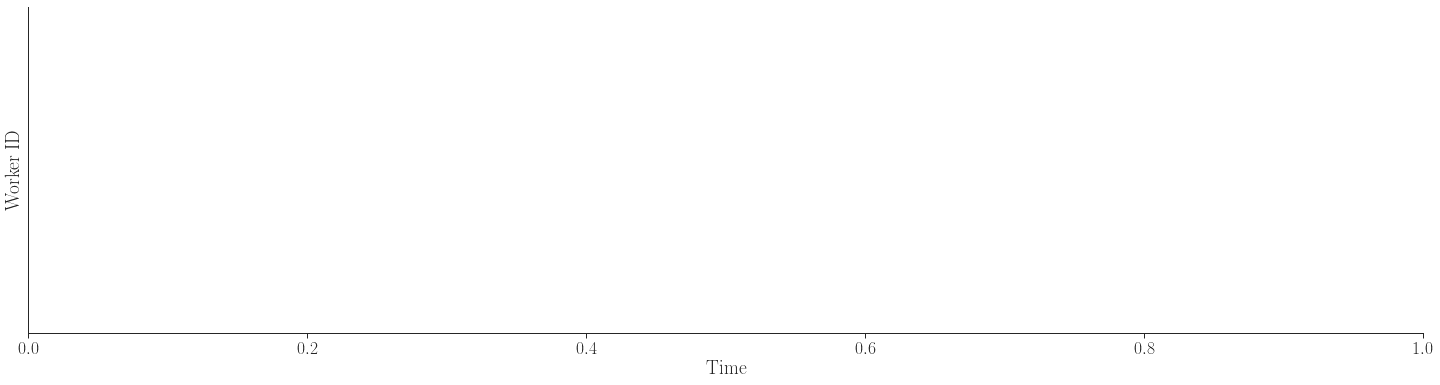

Lambda = 5760.00
{}
Utilization: 89.300%


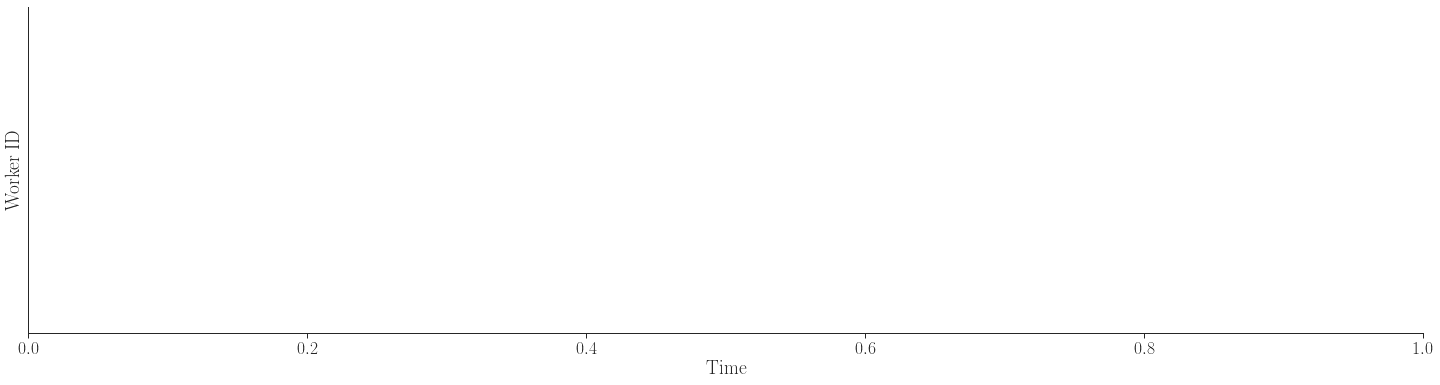

In [20]:
print("V100s=25, P100s=0, K80s=0; Max-Min Fairness")
plot_timeline(
    v100s=25, p100s=0, k80s=0, end=1000000,
    policy="max_min_fairness", seed=0
)

V100s=25, P100s=0, K80s=0; Max-Min Fairness with packing
Lambda = 86400.00
{}
Utilization: 6.900%


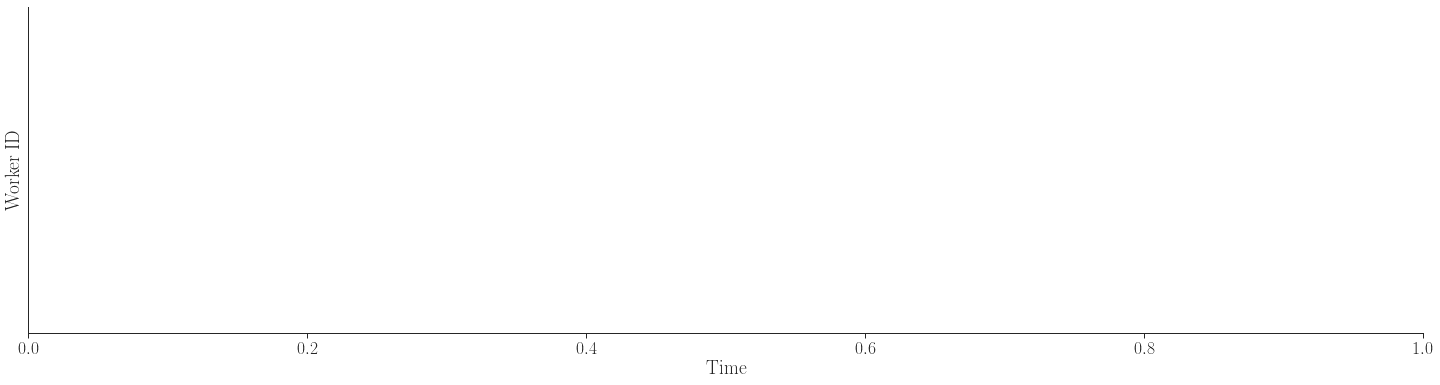

Lambda = 25200.00
{}
Utilization: 20.600%


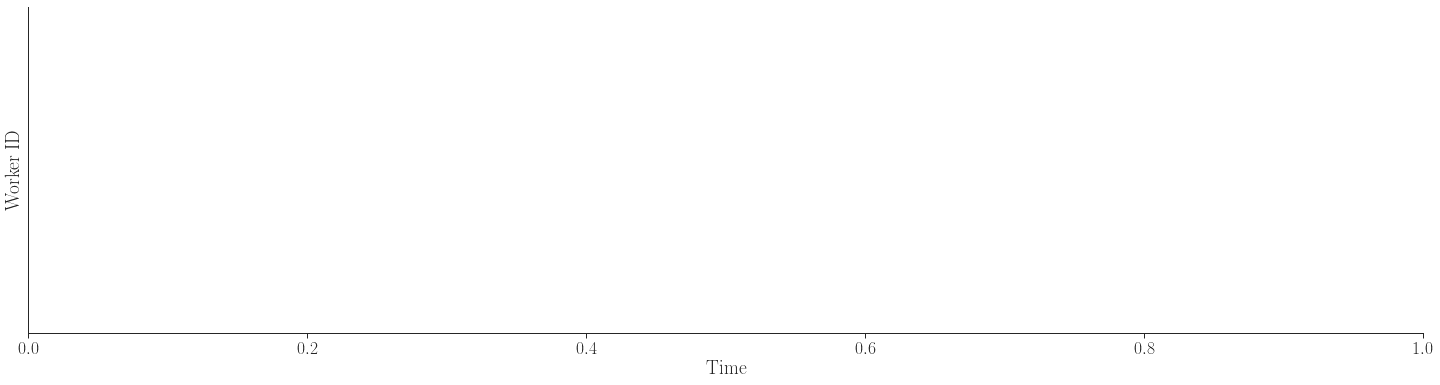

<Figure size 432x288 with 0 Axes>

Lambda = 10080.00
{}
Utilization: 51.200%


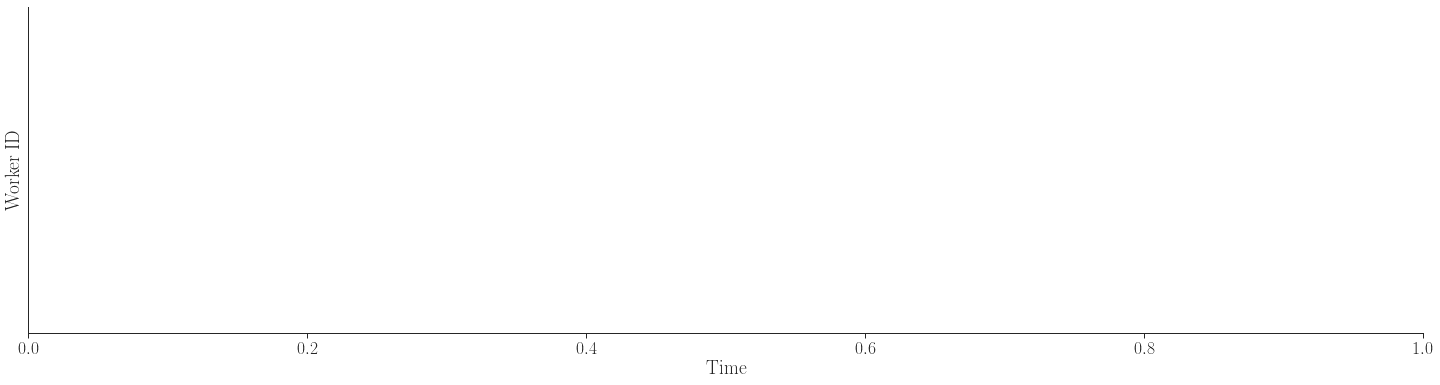

Lambda = 7854.55
{}
Utilization: 65.500%


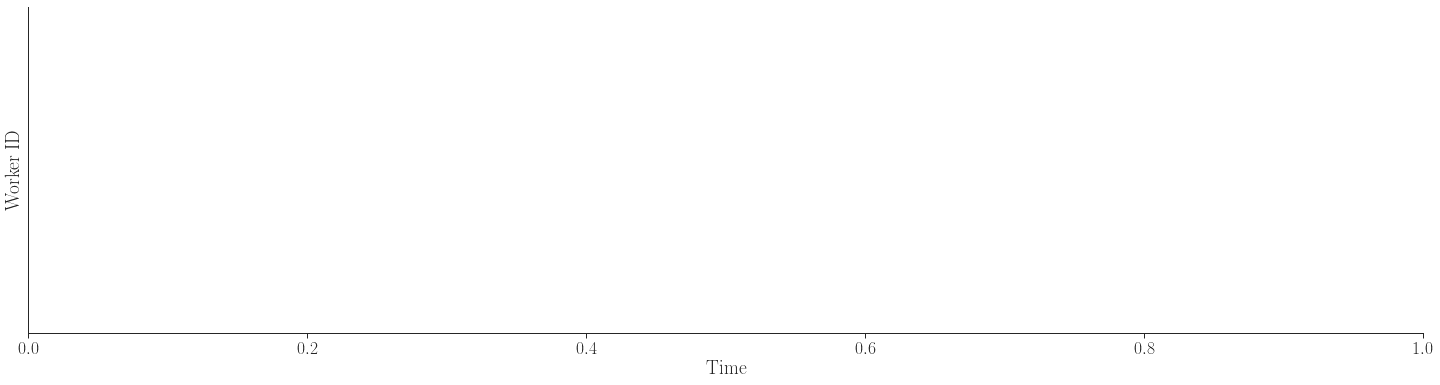

Lambda = 5760.00
{}
Utilization: 87.900%


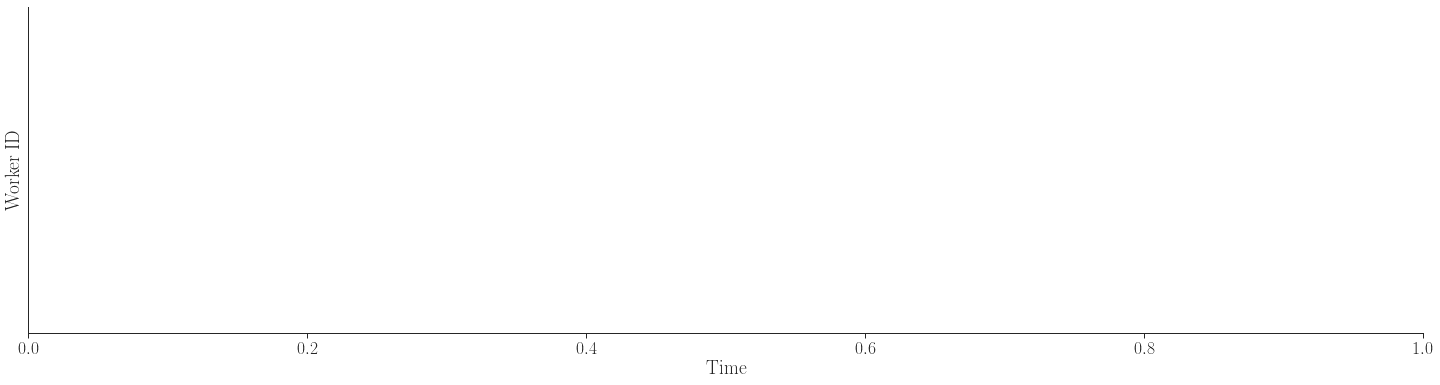

<Figure size 432x288 with 0 Axes>

In [21]:
print("V100s=25, P100s=0, K80s=0; Max-Min Fairness with packing")
plot_timeline(
    v100s=25, p100s=0, k80s=0, end=1000000,
    policy="max_min_fairness_packed", seed=0
)

# Plot output job rate versus input job rate

In [22]:
def output_job_rate_fn(logfile_path, window_size):
    end_timestamps = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            m = re.match(r'\tEnd timestamp: (\d+\.\d+)', line)
            if m is not None:
                end_timestamps.append(float(m.group(1)))

    max_timestamp = max(end_timestamps)
    window = [max_timestamp-window_size, max_timestamp]

    num_completed_jobs = 0
    for end_timestamp in end_timestamps:
        if window[0] <= end_timestamp and end_timestamp <= window[1]:
            num_completed_jobs += 1
    output_job_rate = (num_completed_jobs * 3600) / (window[1] - window[0])
    return output_job_rate

V100s=25, P100s=0, K80s=0; last 1,000,000 seconds


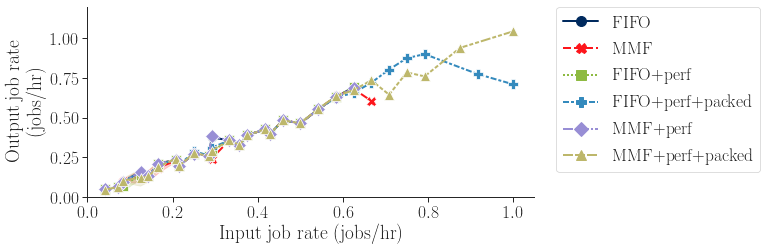

In [23]:
print("V100s=25, P100s=0, K80s=0; last 1,000,000 seconds")
plot_metric_vs_inverse_lambda(
    v100s=25, p100s=0, k80s=0,
    policies=policies,
    metric_fn=lambda x: output_job_rate_fn(
        x, window_size=1000000),
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.2
)

In [ ]:
print("V100s=12, P100s=12, K80s=0; last 1,000,000 seconds")
plot_metric_vs_inverse_lambda(
   v100s=12, p100s=12, k80s=0,
    policies=policies,
    metric_fn=lambda x: output_job_rate_fn(
        x, window_size=1000000),
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)

V100s=12, P100s=12, K80s=0; last 1,000,000 seconds


In [ ]:
print("V100s=16, P100s=8, K80s=0; last 1,000,000 seconds")
plot_metric_vs_inverse_lambda(
   v100s=16, p100s=8, k80s=0,
    policies=policies,
    metric_fn=lambda x: output_job_rate_fn(
        x, window_size=1000000),
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)

In [ ]:
print("V100s=8, P100s=8, K80s=8; last 1,000,000 seconds")
plot_metric_vs_inverse_lambda(
   v100s=8, p100s=8, k80s=8,
    policies=policies,
    metric_fn=lambda x: output_job_rate_fn(
        x, window_size=1000000),
    metric_label="Output job rate\n(jobs/hr)",
    ymax=1.0
)